<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/rvvZiR).**

In [45]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeReg export_graphviz

sns.set(font='DejaVu Sans')

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

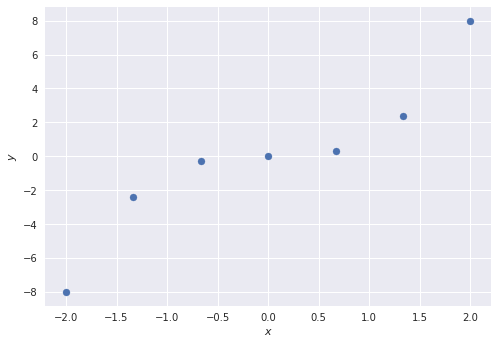

In [291]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

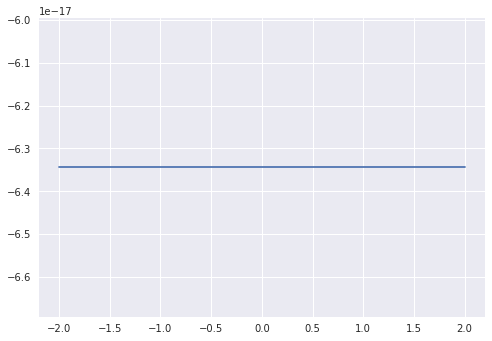

In [324]:
plt.step(X, [np.mean(X) for elm in X]);

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

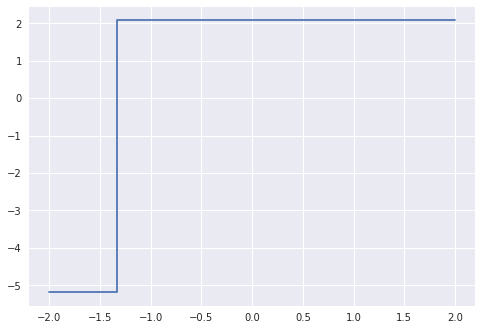

In [323]:
tree = DecisionTreeRegressor(random_state = 17, max_depth = 1)
tree.fit(X.reshape(-1, 1), y.reshape(-1, 1))
tree_predict = tree.predict(X.reshape(-1,1))

plt.step(X, tree_predict);

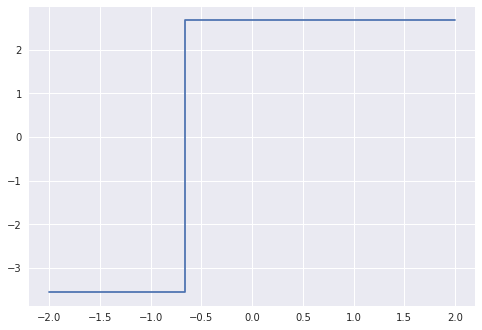

In [322]:
f1 = np.piecewise(X, [X < 0, X >= 0], [np.mean(y[X < 0]), np.mean(y[X >= 0])])
plt.step(X, f1);

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [308]:
def D(X, y):
    yvar = y.sum() / X.size
    sum = 0
    for idx in range(0, y.size):
        sum += np.power(y[idx] - yvar, 2)        
    return sum / X.size

In [309]:
def regression_var_criterion(X, y, t):
    n = X.size
    xl = X[X < t]
    xr = X[X >= t]
    Dl = D(xl, y[X < t])
    Dr = D(xr, y[X >= t])
    return np.sqrt(D(X, y) - Dl * xl.size/n - Dr * xr.size/n)

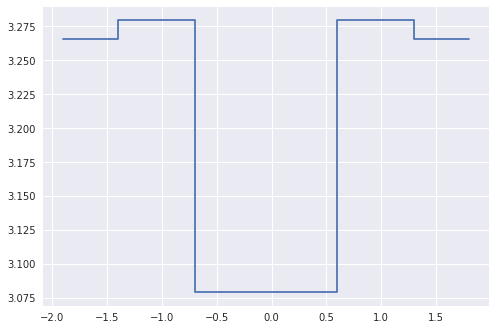

In [321]:
t = np.arange(-1.9, 1.9, 0.1)
plt.step(t, [regression_var_criterion(X, y, elm) for elm in t]);


**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

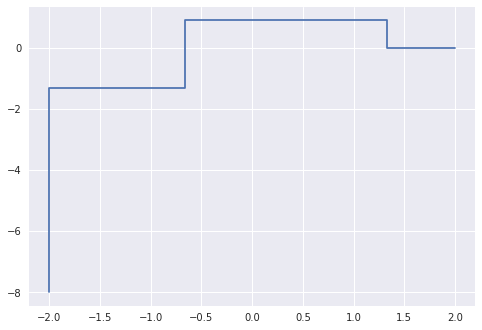

In [319]:
f2 = np.piecewise(X, [X < -1.5, np.logical_and(X >= -1.5, X < 0), np.logical_and(X >= 0, X < 1.5)], \
                  [np.mean(y[X < -1.5]), np.mean(y[np.logical_and(X >= -1.5, X < 0)]), \
                   np.mean(y[np.logical_and(X >= 0, X < 1.5)])])
plt.step(X, f2);

**<font color='red'>Вопрос 2.</font> Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [340]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [341]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах", а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`.

In [342]:
df['age_years'] = round(df['age']/365.25).astype(int);

In [343]:
df['chol1'] = pd.get_dummies(df['cholesterol'])[1]
df['chol2'] = pd.get_dummies(df['cholesterol'])[2]
df['chol3'] = pd.get_dummies(df['cholesterol'])[3]
df.drop('cholesterol', axis = 1, inplace = True)

In [347]:
df['gluc1'] = pd.get_dummies(df['gluc'])[1]
df['gluc2'] = pd.get_dummies(df['gluc'])[2]
df['gluc3'] = pd.get_dummies(df['gluc'])[3]
df.drop('gluc', axis = 1, inplace = True)

In [348]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_years,chol1,chol2,chol3,gluc1,gluc2,gluc3
id,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,0,50,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,1,55,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,0,0,0,1,52,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,0,0,1,1,48,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,0,48,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [354]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop('cardio', axis=1), df['cardio'], \
                                                      test_size= 0.3, random_state = 17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [368]:
tree = DecisionTreeClassifier(criterion='gini', random_state = 17, max_depth = 3, max_features=None)

In [370]:
tree.fit(X_train, y_train);

In [377]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file = 'cardio_tree.dot', feature_names = X_train.columns, filled = True)
#!dot -Tpng cardio_tree.dot -o cardio_tree.png

/bin/sh: 1: dot: not found


<img src="../topic03_decision_trees_knn/cardio_tree.png" />

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [419]:
tree_valid_pred = tree.predict(X_valid)

from sklearn.metrics import accuracy_score
acc1 = accuracy_score(y_valid, tree_valid_pred)
acc1

0.72128571428571431

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [423]:
tree_params = {'max_depth': list(range(2, 11))}
tree_grid = GridSearchCV(tree, tree_params, cv = 5, n_jobs = -1)

In [424]:
%%time
tree_grid.fit(X_train, y_train)

CPU times: user 330 ms, sys: 80 ms, total: 410 ms
Wall time: 1.54 s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

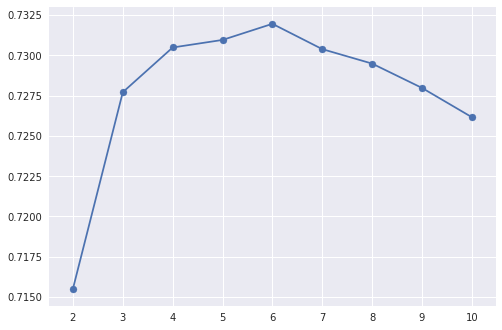

In [431]:
max_depth = tree_grid.cv_results_['param_max_depth'].data
accuracy = tree_grid.cv_results_['mean_test_score']
plt.plot(max_depth, accuracy);
plt.scatter(max_depth, accuracy);

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [416]:
tree_grid.best_score_, tree_grid.best_params_

(0.73195918367346935, {'max_depth': 6})

In [422]:
acc2 = accuracy_score(y_valid, tree_grid.best_estimator_.predict(X_valid))
100 * (acc2 - acc1)/acc1

0.62718690169670033

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках.

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [453]:
df['age_4550'] = np.logical_and(df['age_years'] >= 45, df['age_years'] < 50).astype(int)
df['age_5055'] = np.logical_and(df['age_years'] >= 50, df['age_years'] < 55).astype(int)
df['age_5560'] = np.logical_and(df['age_years'] >= 55, df['age_years'] < 60).astype(int)
df['age_6066'] = np.logical_and(df['age_years'] >= 60, df['age_years'] < 65).astype(int)

df['aphi_120140'] = np.logical_and(df['ap_hi'] >= 120, df['ap_hi'] < 140).astype(int)
df['aphi_140160'] = np.logical_and(df['ap_hi'] >= 140, df['ap_hi'] < 160).astype(int)
df['aphi_160180'] = np.logical_and(df['ap_hi'] >= 160, df['ap_hi'] < 180).astype(int)

df['male'] = df['gender'] - 1

In [454]:
cardio_tree = DecisionTreeClassifier(random_state = 17, max_depth= 3)

In [456]:
y2 = df['cardio']
X2 = df[['male', 'chol1', 'chol2', 'chol3', 'smoke', 'age_4550', 'age_5055', 'age_5560', 'age_6066', 'aphi_120140', 'aphi_140160', 'aphi_160180']]
cardio_tree.fit(X2, y2)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

In [457]:
export_graphviz(cardio_tree, out_file = 'cardio_tree2.dot', feature_names = X2.columns, filled = True)
#!dot -Tpng cardio_tree2.dot -o cardio_tree2.png

<img src="../topic03_decision_trees_knn/cardio_tree2.png" />